<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Dataset-Overview" data-toc-modified-id="Dataset-Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dataset Overview</a></span></li><li><span><a href="#Part-A:-Data-Preprocessing" data-toc-modified-id="Part-A:-Data-Preprocessing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Part A: Data Preprocessing</a></span></li><li><span><a href="#Part-B:-Exploratory-Data-Analysis" data-toc-modified-id="Part-B:-Exploratory-Data-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Part B: Exploratory Data Analysis</a></span></li><li><span><a href="#Part-C:-Feature-Construction" data-toc-modified-id="Part-C:-Feature-Construction-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Part C: Feature Construction</a></span></li><li><span><a href="#Part-D:-Model-Training-and-Evaluation" data-toc-modified-id="Part-D:-Model-Training-and-Evaluation-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Part D: Model Training and Evaluation</a></span></li><li><span><a href="#Part-E:-Model-Deployment" data-toc-modified-id="Part-E:-Model-Deployment-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Part E: Model Deployment</a></span><ul class="toc-item"><li><span><a href="#Deployment-specification" data-toc-modified-id="Deployment-specification-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Deployment specification</a></span></li></ul></li><li><span><a href="#Part-F:-Follow-up-questions" data-toc-modified-id="Part-F:-Follow-up-questions-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Part F: Follow-up questions</a></span></li></ul></div>

# Final Exam Project: Amazon Review Rating Prediction

In this project, you are provided with a dataset of [Amazon product reviews](https://s3.amazonaws.com/amazon-reviews-pds/readme.html). You will apply what you have learned in this course to analyze the dataset and build a predictive model of review ratings. Your deliverables consist of:

1. **scoring_uri.txt**. After training your model, you will deploy it to a public endpoint on Azure, similar to what you did in Project 6 and 7. Your endpoint URI should be included in this file. The autograder will send test data to your endpoint and evaluate the accuracy of your model's predictions. This part is worth 30 points.
    * 15 points are awarded when your model is deployed successfully. The autograder will send a request to your deployed URI, then check that the status code is 200 and the response JSON is correctly formatted.
    * 15 points are awarded when your deployed model also meets the accuracy requirement. The grader will compare your predicted labels with the ground truth labels to determine the accuracy score.
1. **This notebook**. While the autograder will **not** be running your code, there are a number of follow-up questions in Part F that you should answer. **You are encouraged to look at these questions before you start coding.** These are manually graded and worth 40 points.
1. **references**. Include your reference sources here.

In each of the following sections, we will provide some high-level suggestions. You are free to decide on your implementations, or choose a different direction. You can also import any Python package that you find useful, or reuse any of the code you had written in prior projects (remember to mention any reused code in the `references` file).

One point to keep in mind as you begin planning your data processing pipeline is that any processing object that has been fit on the training data (e.g., sklearn's `TfidfVectorizer` or `LogisticRegression`) should later be saved to pickle files and included in the deployment step, so that you can use them to transform or predict the test data. See Section 1 in the [Model deployment primer](https://nbviewer.jupyter.org/url/clouddatascience.blob.core.windows.net/primers/machine-learning-azure-primer/azure_model_deployment_primer.ipynb) on the common pitfalls in loading custom functions or classes in the Azure deployment environment. Note that it is possible to complete every task in this exam without defining any custom function.

We start by importing some basic packages. Feel free to remove or add any others as you progress through the tasks.

In [1]:
import pickle, re, requests, json, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.sparse import hstack
from scipy.sparse import csr_matrix

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from bs4 import BeautifulSoup
import string

import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score

import joblib

## Dataset Overview
Our dataset is included in the tab-delimited file `amazon_reviews.tsv`. Here is a brief description of the dataframe columns:

<br>

| Column name 	| Description 	|
|-	|-	|
| marketplace 	| 2 letter country code of the marketplace where the review was written. 	|
| customer_id 	| Random identifier that can be used to aggregate reviews written by a single author. 	|
| review_id 	| The unique ID of the review. 	|
| product_id 	| The unique Product ID the review pertains to. In the multilingual dataset the reviews for the same product in different countries can be grouped by the same product_id. 	|
| product_parent 	| Random identifier that can be used to aggregate reviews for the same product. 	|
| product_title 	| Title of the product. 	|
| product_category 	| Broad product category that can be used to group reviews (also used to group the dataset into coherent parts). 	|
| helpful_votes 	| Number of helpful votes. 	|
| total_votes 	| Number of total votes the review received. 	|
| vine 	| Review was written as part of the Vine program. 	|
| verified_purchase 	| The review is on a verified purchase. 	|
| review_headline 	| The title of the review. 	|
| review_body 	| The review text. 	|
| review_date 	| The date the review was written. 	|
| **star_rating** 	| The 1-5 star rating of the review. 	|

<br>

The column which we will need to predict is `star_rating`, which contains integer values from 1 to 5 (inclusive). While the nature of this problem is ordinal regression, for simplicity in this project, we will only treat it as a multi-class classification problem. In other words, we assume each review is associated with one label (1, 2, 3, 4 or 5), and attempt to predict a review's label based on its content and metadata.

We provide the starting code to read the data for you. Note that there are some malformed rows in the original tsv file, so we set `error_bad_lines` to `False`.

In [2]:
def read_data():
    return pd.read_csv("amazon_reviews.tsv", sep="\t", header=0, on_bad_lines='skip', dtype={
        "marketplace": str,
        "customer_id":str,
        "review_id":str,
        "product_id":str,
        "product_parent":str,
        "product_title":str,
        "product_category":str,
        "star_rating":int,
        "helpful_votes":int,
        "total_votes":int,
        "vine":str,
        "verified_purchase":str,
        "review_headline":str,
        "review_body":str,
        "review_date":str
    })

df_reviews = read_data()

## Part A: Data Preprocessing
Since this project only involves review rating prediction, you can remove the following irrelevant features:

* `marketplace`
* `customer_id`
* `review_id` 
* `product_id`
* `product_parent`
* `product_category`(since all the products belong to the same category)
* `review_date`

The primary rating predictor will be the review content (i.e., `review_body`). We suggest you perform the following preprocessing tasks from **Project 4** on `review_body`.
* Remove all html tags.
* Clean punctuations and special characters.
* Apply lower casing.
* Tokenize the content, then apply stemming or lemmatization to each token.
* Remove English stopwords.

In [3]:
## YOUR DATA PREPROCESSING CODE HERE ##

In [4]:
nltk.download("stopwords", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)

True

In [5]:
lemmatizer = WordNetLemmatizer()
english_stopwords = set(nltk.corpus.stopwords.words('english'))

In [6]:
df_reviews.drop(['marketplace', 'customer_id', 'review_id', 'product_id', 'product_parent', 'product_category', 'review_date'], axis=1, inplace=True)

In [7]:
def clean_text(text):
    if pd.isna(text):
        return ""
    text = BeautifulSoup(text, "html.parser").get_text()
    text = text.lower()
    text = re.sub(r"'s\b", "", text)
    text = re.sub("[^a-zA-Z]", " ", text)
    text = re.sub(r"'s(\s|$)", r"\1", text)
    text = text.replace("'", "")
    text = text.strip()
    return text

def tokenize(text):
    data = nltk.word_tokenize(text)
    valid = set(string.ascii_letters + string.digits)
    tokens = []
    for token in data:
        subtoken = ''
        subtokens = []
        for char in token:
            if char in valid:
                subtoken += char
            else:
                if subtoken:
                    subtokens.append(subtoken)
                    subtoken = ''
        if subtoken:
            subtokens.append(subtoken)
        tokens.extend(subtokens)
    return tokens

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize(tokens):
    tagged_tokens = nltk.pos_tag(tokens)
    lemmatized_tokens = []
    for word, tag in tagged_tokens:
        wntag = get_wordnet_pos(tag)
        lemmatized_token = lemmatizer.lemmatize(word, pos=wntag)
        if lemmatized_token not in english_stopwords and len(lemmatized_token) > 1:
            lemmatized_tokens.append(lemmatized_token)
    return lemmatized_tokens

def preprocess_text(text):
    if pd.isna(text):
        return ""
    cleaned_text = clean_text(text)
    tokens = tokenize(cleaned_text)
    lemmatized_tokens = lemmatize(tokens)
    return ' '.join(lemmatized_tokens)

In [8]:
df_reviews['processed_review'] = df_reviews['review_body'].apply(preprocess_text)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/bs4/__init__.py:337: MarkupResemblesLocatorWarning: "." looks like a directory name, not markup. You may want to open a file found in this directory and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [9]:
df_reviews[['review_body', 'processed_review']].head()

,review_body,processed_review
0,I bought this as a gift for my son and he real...,buy gift son really like pair well iphone ipad...
1,I like this case as it is secure and I can han...,like case secure hang ipod neck exercise walk ...
2,It showed up on time but the remote did not pr...,show time remote properly work function tv nee...
3,Excellent product excellent customer service. ...,excellent product excellent customer service f...
4,"Great bundle,everything works,very satisfied w...",great bundle everything work satisfied purchas...


## Part B: Exploratory Data Analysis
You should investigate the feature and label distributions in your exploratory data analysis. A good starting point is the techniques and tools from **Project 3**, in particular the Pandas Profiler library. Pay attention to rows with missing data or outliers, and think about whether to include or remove them. In case the rating distribution is highly imbalanced, you may also consider oversampling the minority classes (i.e., making random copies of the rows with the minority classes) to get a more balanced sample. However, oversampling should only be performed in part D on the training data only, after you have performed a train-test split.

In [10]:
## YOUR EXPLORATORY DATA ANALYSIS CODE HERE ##

In [11]:
df_reviews.head()

,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,processed_review
0,Jawbone Jambox Wireless Bluetooth Speaker - Bl...,5,0,0,N,Y,Good thing in a small package,I bought this as a gift for my son and he real...,buy gift son really like pair well iphone ipad...
1,Green Silicone skin sport nano case for Apple ...,3,6,6,N,N,Good enough,I like this case as it is secure and I can han...,like case secure hang ipod neck exercise walk ...
2,original brand new proscan TV remote control F...,1,0,0,N,Y,... it to even though it was advertised to wor...,It showed up on time but the remote did not pr...,show time remote properly work function tv nee...
3,Bluetooth Headphones - Fit Acoustics Wireless ...,5,1,1,N,Y,Excellent product excellent customer service,Excellent product excellent customer service. ...,excellent product excellent customer service f...
4,TsirTech 18 Items Luxury Accessory Bundle for ...,5,0,0,N,Y,"great bundle, love the texting glove,","Great bundle,everything works,very satisfied w...",great bundle everything work satisfied purchas...


In [12]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99909 entries, 0 to 99908
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   product_title      99909 non-null  object
 1   star_rating        99909 non-null  int64 
 2   helpful_votes      99909 non-null  int64 
 3   total_votes        99909 non-null  int64 
 4   vine               99909 non-null  object
 5   verified_purchase  99909 non-null  object
 6   review_headline    99909 non-null  object
 7   review_body        99909 non-null  object
 8   processed_review   99909 non-null  object
dtypes: int64(3), object(6)
memory usage: 6.9+ MB


In [13]:
df_reviews.describe()

,star_rating,helpful_votes,total_votes
count,99909.000000,99909.000000,99909.000000
mean,3.898818,1.496962,1.934190
std,1.462946,10.741559,11.758621
min,1.000000,0.000000,0.000000
25%,3.000000,0.000000,0.000000
50%,5.000000,0.000000,0.000000
75%,5.000000,1.000000,1.000000
max,5.000000,1219.000000,1234.000000


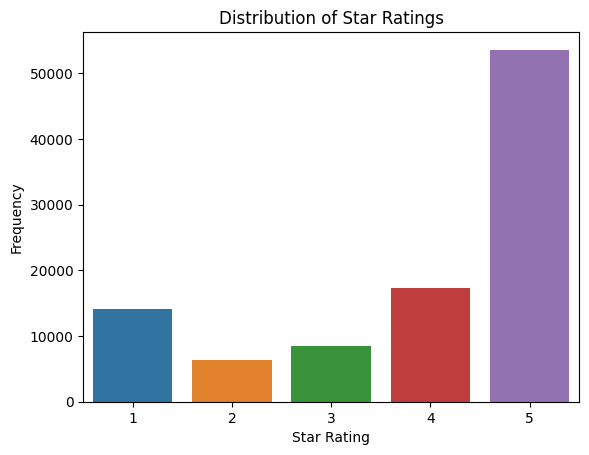

In [14]:
sns.countplot(x='star_rating', data=df_reviews)
plt.title('Distribution of Star Ratings')
plt.xlabel('Star Rating')
plt.ylabel('Frequency')
plt.show()

In [15]:
print(df_reviews.isnull().sum())

product_title        0
star_rating          0
helpful_votes        0
total_votes          0
vine                 0
verified_purchase    0
review_headline      0
review_body          0
processed_review     0
dtype: int64


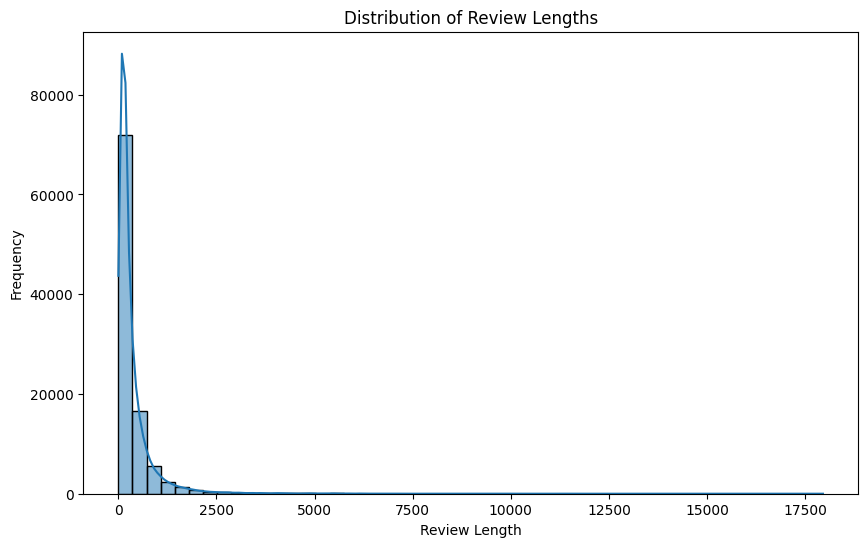

In [16]:
df_reviews['review_length'] = df_reviews['review_body'].apply(len)

plt.figure(figsize=(10, 6))
sns.histplot(df_reviews['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()

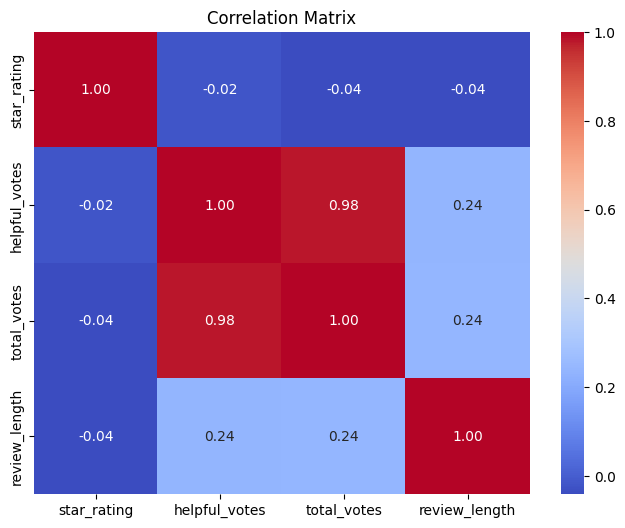

In [17]:
correlation_matrix = df_reviews[['star_rating', 'helpful_votes', 'total_votes', 'review_length']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [18]:
df_reviews.shape

(99909, 10)

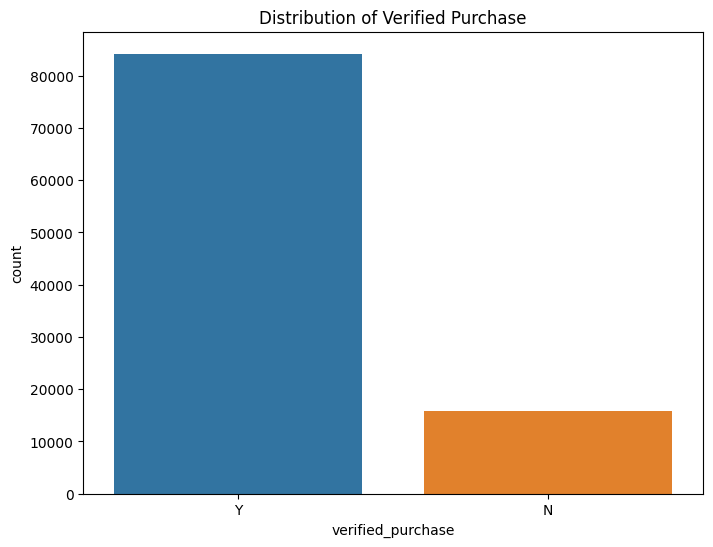

In [19]:
plt.figure(figsize=(8, 6))
sns.countplot(x='verified_purchase', data=df_reviews)
plt.title('Distribution of Verified Purchase')
plt.show()

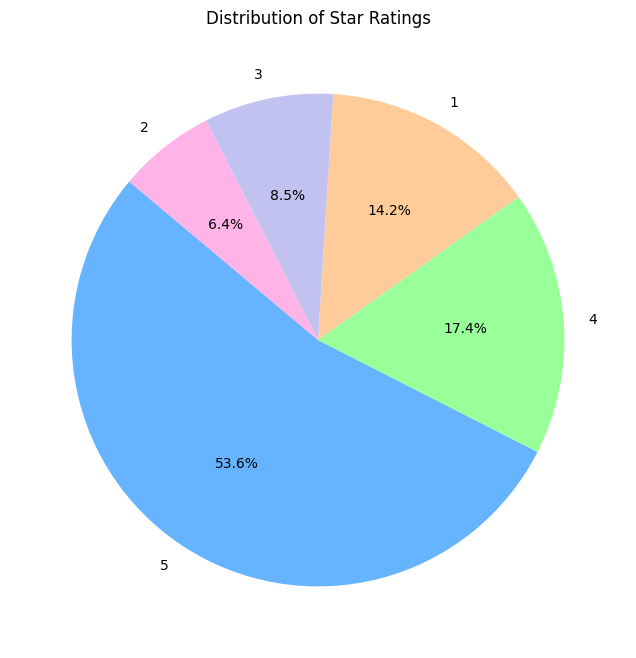

In [20]:
rating_counts = df_reviews['star_rating'].value_counts()

plt.figure(figsize=(8, 8))
plt.pie(rating_counts, labels=rating_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#99ff99','#ffcc99','#c2c2f0','#ffb3e6'])
plt.title('Distribution of Star Ratings')
plt.show()

## Part C: Feature Construction
The next task is to construct numerical features for prediction. We recommend starting with frequency-based features, such as TF and TF-IDF from **Project 5**, based on the review text content. To avoid potential memory issues, make sure to select the best data representation for your feature matrix. For example, TF-IDF matrices should be in sparse format, which you worked with in **Project 2**.

Once you have finished the model deployment, feel free to revisit this section and experiment with other features (such as those from **Project 7**) to improve your model accuracy. Pay attention to how different data structures can be used to optimize feature construction (e.g., list vs set vs iterator), which you learned in **Project 1**.

In [10]:
## YOUR FEATURE CONSTRUCTION CODE HERE ##

In [11]:
def create_additional_features(df):
    df['review_length'] = df['review_body'].apply(len)
    df['helpfulness_ratio'] = df['helpful_votes'] / df['total_votes'].replace(0, 1)
    df['vine_program'] = (df['vine'] == 'Y').astype(int)
    df['verified_purchase'] = (df['verified_purchase'] == 'Y').astype(int)
    return df[['review_length', 'helpfulness_ratio', 'vine_program', 'verified_purchase']]

additional_features = create_additional_features(df_reviews)

In [23]:
X = df_reviews['processed_review'].fillna('')
y = df_reviews['star_rating']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_features, test_features = train_test_split(additional_features, test_size=0.2, random_state=42)

In [27]:
def apply_tfidf_vectorization(train_data, test_data):
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
    X_train_tfidf = vectorizer.fit_transform(train_data)
    X_test_tfidf = vectorizer.transform(test_data)
    feature_names = vectorizer.get_feature_names_out()
    return X_train_tfidf, X_test_tfidf, feature_names

X_train_tfidf, X_test_tfidf, feature_names = apply_tfidf_vectorization(X_train, X_test)

In [28]:
train_features_sparse = csr_matrix(train_features)
test_features_sparse = csr_matrix(test_features)

X_train_combined = hstack([X_train_tfidf, train_features_sparse])
X_test_combined = hstack([X_test_tfidf, test_features_sparse])

## Part D: Model Training and Evaluation
It is now time to train machine learning models to predict review ratings. Your goal in this part is to come up with a model that can achieve an **accuracy score of at least 0.60 on the test data**. Given the ground truth labels `y_true` and your predicted labels `y_pred` (each of which contains integer values from 1 to 5), the grader environment will compute the accuracy score as `sklearn.metrics.accuracy_score(y_true, y_pred)`.


As a starting point, you can try out the classical learning algorithms supported by Sklearn:

* Logistic regression
* Support vector machine
* K-nearest neighbor

You can also experiment with some ensemble methods based on these classifiers, for example [voting classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html) or [boosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html). You can tune the hyperparameters for each learning algorithm, using the cross validation process in **Project 5**, to identify the best fit model.

**Notes**:
* Similar to **Project 6**, your trained model will be evaluated on a secret test dataset. Its accuracy on this dataset will be shown in the Sail() Feedback view when you make a submission.

In [29]:
## YOUR MODEL TRAINING CODE HERE ##

In [30]:
logistic_model = LogisticRegression(max_iter=7000)
svm_model = SVC(random_state=42, max_iter=5000, verbose=1)
knn_model = KNeighborsClassifier(n_neighbors=5)
rf_model = RandomForestClassifier(n_estimators=420, random_state=42)

In [31]:
models = [logistic_model, knn_model, rf_model, svm_model]

for model in models:
    model.fit(X_train_combined, y_train)
    y_pred = model.predict(X_test_combined)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy of {model.__class__.__name__}: {accuracy}')

Accuracy of LogisticRegression: 0.6478830947853068
Accuracy of KNeighborsClassifier: 0.4671704534080673
Accuracy of RandomForestClassifier: 0.6326193574216795
[LibSVM]....WARN: libsvm Solver reached max_iter
optimization finished, #iter = 5000
obj = -9992.810143, rho = -0.377856
nSV = 10000, nBSV = 10000
....WARN: libsvm Solver reached max_iter
optimization finished, #iter = 5000
obj = -10000.591093, rho = -0.023702
nSV = 10000, nBSV = 10000
....WARN: libsvm Solver reached max_iter
optimization finished, #iter = 5000
obj = -9994.507028, rho = -0.002800
nSV = 10000, nBSV = 10000
....WARN: libsvm Solver reached max_iter
optimization finished, #iter = 5000
obj = -9999.133439, rho = -0.000496
nSV = 10000, nBSV = 10000
....WARN: libsvm Solver reached max_iter
optimization finished, #iter = 5000
obj = -9395.174215, rho = -0.286973
nSV = 10000, nBSV = 10000
....WARN: libsvm Solver reached max_iter
optimization finished, #iter = 5000
obj = -10004.937956, rho = 0.203163
nSV = 10000, nBSV = 1000

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy of SVC: 0.48378540686617955


In [ ]:
def cross_validate_model(model, X, y, folds=5):
    scores = cross_val_score(model, X, y, cv=folds, scoring='accuracy')
    return np.mean(scores)

In [ ]:
X_combined = vstack([X_train_combined, X_test_combined])
y_combined = np.concatenate([y_train, y_test])

for model in models:
    avg_accuracy = cross_validate_model(model, X_combined, y_combined)
    print(f'Average Cross-Validation Accuracy of {model.__class__.__name__}: {avg_accuracy}')

In [32]:
voting_classifier = VotingClassifier(
    estimators=[
        ('lr', logistic_model),
        ('knn', knn_model),
        ('rf', rf_model),
        ('svm', svm_model)
    ],
    voting='hard'
)

voting_classifier.fit(X_train_combined, y_train)
ensemble_pred = voting_classifier.predict(X_test_combined)
ensemble_accuracy = accuracy_score(y_test, ensemble_pred)
print(f'Accuracy of Voting Classifier: {ensemble_accuracy}')

[LibSVM]....WARN: libsvm Solver reached max_iter
optimization finished, #iter = 5000
obj = -9992.810143, rho = -0.377856
nSV = 10000, nBSV = 10000
....WARN: libsvm Solver reached max_iter
optimization finished, #iter = 5000
obj = -10000.591093, rho = -0.023702
nSV = 10000, nBSV = 10000
....WARN: libsvm Solver reached max_iter
optimization finished, #iter = 5000
obj = -9994.507028, rho = -0.002800
nSV = 10000, nBSV = 10000
....WARN: libsvm Solver reached max_iter
optimization finished, #iter = 5000
obj = -9999.133439, rho = -0.000496
nSV = 10000, nBSV = 10000
....WARN: libsvm Solver reached max_iter
optimization finished, #iter = 5000
obj = -9395.174215, rho = -0.286973
nSV = 10000, nBSV = 10000
....WARN: libsvm Solver reached max_iter
optimization finished, #iter = 5000
obj = -10004.937956, rho = 0.203163
nSV = 10000, nBSV = 10000
....WARN: libsvm Solver reached max_iter
optimization finished, #iter = 5000
obj = -10012.173308, rho = 0.151331
nSV = 10000, nBSV = 10000
....WARN: libsvm S

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=5000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy of Voting Classifier: 0.6315183665298769


Once you have identified your best model, you can fit it on the entire dataset and save all relevant data processing objects to files in a `models` directory, so that you can use it as your deployment directory in the next part.

**Notes**:
* Your model file names should not contain any space character.

In [12]:
## YOUR MODEL SAVING CODE HERE ##

def apply_tfidf_vectorization(data):
    vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))
    X_tfidf = vectorizer.fit_transform(data)
    feature_names = vectorizer.get_feature_names_out()
    return X_tfidf, vectorizer, feature_names

X_tfidf, vectorizer, feature_names = apply_tfidf_vectorization(df_reviews['processed_review'].fillna(''))

In [16]:
logistic_model = LogisticRegression(max_iter=1000)

In [17]:
logistic_model.fit(X_tfidf, df_reviews['star_rating'])

LogisticRegression(max_iter=1000)

In [18]:
model_directory = 'models'
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
    
joblib.dump(logistic_model, os.path.join(model_directory, 'logistic_regression_model.pkl'))
joblib.dump(vectorizer, os.path.join(model_directory, 'tfidf_vectorizer.pkl'))

['models/tfidf_vectorizer.pkl']

## Part E: Model Deployment

Now you will deploy your model to a local endpoint, test it on some sample data, and then deploy the model to a public endpoint -- this is the same process you performed in **Project 6 and 7**. You can follow the steps in the [Model deployment primer](https://nbviewer.jupyter.org/url/clouddatascience.blob.core.windows.net/primers/machine-learning-azure-primer/azure_model_deployment_primer.ipynb). Make sure to pay attention to how it handles custom functions and classes, if you used them in previous steps. Note also that for `myenv.yml`, you should list all the pip packages that you have used in this project, along with their version number.

### Deployment specification

Our grader will send a POST request to your endpoint, where the JSON content will be structured as follows:

```python
request_content = """{
    "n_reviews" : 2,
    "reviews" : [
        {
            "marketplace" : "US",
            "customer_id" : "20422322",
            "review_id" : "R8MEA6IGAHO0B",
            "product_id" : "B00MC4CED8",
            "product_parent" : "217304173",
            "product_title" : "BlackVue",
            "product_category" : "Mobile_Electronics",
            "helpful_votes" : 0,
            "total_votes" : 0,
            "vine" : "N",
            "verified_purchase" : "Y",
            "review_headline" : "Very Happy!	As advertised.",
            "review_body" : "Everything works perfectly, I'm happy",
            "review_date" : "2015-08-31"
        },
        {
            "marketplace" : "US",
            "customer_id" : "15204307",
            "review_id" : "RZGDLDMGMGKLB",
            "product_id" : "B000I3F91O",
            "product_parent" : "90621845",
            "product_title" : "Sangean H205 AM/FM Weather Alert Waterproof",
            "product_category" : "Electronics",
            "helpful_votes" : 0,
            "total_votes" : 0,
            "vine" : "N",
            "verified_purchase" : "Y",
            "review_headline" : "Best shower radio I have ever owned",
            "review_body" : "love shower radio own shower radio best one",
            "review_date" : "2014-11-08"
        },
    ]
}
"""
```

Here `n_reviews` indicates the number of reviews included in the request, and `reviews` is a list of dictionaries, each having the same schema as a row in the provided dataset (but without the `star_rating` attribute, which is what you need to predict).

The expected response is a JSON with the following format:

```python
response_content = {
    "predictions" : [2, 3]
}
```
where the key `predictions` maps to a list of predicted labels, one for each input review in `request_content`. Keep in mind that this list should be a standard Python list, not a Numpy array or Pandas series, which are not JSON serializable.

**Notes**:
* If you have put your custom functions / classes in a separate Python file, for example `my_custom_code.py` in the current directory, this file will be sent to the deployment environment as well. Therefore, you can include `import my_custom_code` in your scoring script.
* If you use `nltk` in your data processing, note that the Docker environment used for deployment does not have any NLTK data by default. Therefore, you may need to explicitly download them in your `init` function, for example `nltk.download("stopwords")`. If you use the text processing code from Project 4, refer to the `nltk.download` commands provided at the beginning of the Project 4 notebook.

In [19]:
## YOUR ENVIRONMENT SETUP CODE HERE ##
import azureml.core
from azureml.core.workspace import Workspace
from azureml.core.model import Model
from azureml.core.webservice import LocalWebservice, AciWebservice
from azureml.core.model import InferenceConfig
from azureml.core.webservice import Webservice
from azureml.core.model import Model
from azureml.core.environment import Environment
from azureml.core.conda_dependencies import CondaDependencies 

In [ ]:
ws = Workspace.from_config()
print('Workspace name: ' + ws.name, 
      'Azure region: ' + ws.location, 
      'Subscription id: ' + ws.subscription_id, 
      'Resource group: ' + ws.resource_group, sep='\n')

In [ ]:
model_path = './models/logistic_regression_model.pkl'
vectorizer_path = './models/tfidf_vectorizer.pkl'

register_LR_model = Model.register(workspace=ws,
                                  model_name='LogisticRegression',
                                  model_path=model_path,
                                  description='Logistic Regression model')

register_Vectorizer = Model.register(workspace=ws,
                                    model_name='TFIDF_Vectorizer',
                                    model_path=vectorizer_path,
                                    description='TF-IDF Vectorizer')

In [61]:
%%writefile ./score.py
## YOUR SCORE.PY CODE HERE ##
import json
import os
import joblib
import pandas as pd
from azureml.core.model import Model
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from bs4 import BeautifulSoup
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords', quiet=True)
english_stopwords = set(stopwords.words('english'))

lemmatizer = WordNetLemmatizer()
english_stopwords = set(nltk.corpus.stopwords.words('english'))

def init():
    global model, vectorizer
    model_path = Model.get_model_path('LogisticRegressionModel')
    vectorizer_path = Model.get_model_path('TFIDFVectorizer')
    
    model = joblib.load(model_path)
    vectorizer = joblib.load(vectorizer_path)
   
def preprocess_text(text):
    if pd.isna(text):
        return ""
    text = BeautifulSoup(text, "html.parser").get_text()
    text = re.sub(r"[^a-zA-Z]", " ", text.lower()).strip()
    words = text.split()
    cleaned_words = [word for word in words if word not in english_stopwords]
    return ' '.join(cleaned_words)

def run(raw_data):
    try:
        data = json.loads(raw_data)
        
        reviews = data['reviews']
        review_texts = [review['review_body'] for review in reviews]
        
        processed_texts = [preprocess_text(text) for text in review_texts]
        
        features = vectorizer.transform(processed_texts)
        
        predictions = model.predict(features)
        
        return json.dumps({"predictions": predictions.tolist()})
    except Exception as e:
        error = {"error": str(e)}
        return json.dumps(error)

Overwriting ./score.py


In [62]:
!cat score.py

## YOUR SCORE.PY CODE HERE ##
import json
import os
import joblib
import pandas as pd
import re
from bs4 import BeautifulSoup
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
from nltk import pos_tag, word_tokenize
from azureml.core.model import Model

lemmatizer = WordNetLemmatizer()
english_stopwords = set(nltk.corpus.stopwords.words('english'))

def init():
    global model, vectorizer
    try:
        model_path = Model.get_model_path('LogisticRegression')
        vectorizer_path = Model.get_model_path('TFIDF_Vectorizer')
        model = joblib.load(model_path)
        vectorizer = joblib.load(vectorizer_path)
        print("Model and vectorizer loaded successfully.")
    except Exception as e:
        print(f"Error loading model or vectorizer: {e}")
        raise e
    
def run(raw_data):
    try:
        data = json.loads(raw_data)
        rev

In [63]:
environment_file = CondaDependencies.create(pip_packages=[
    'azureml-defaults', 
    'numpy', 
    'pandas', 
    'scikit-learn', 
    'nltk', 
    'beautifulsoup4', 
    'joblib',
    'azureml-core', 
    'scipy',
    'regex',
])

with open("myenv.yml","w") as f:
    f.write(environment_file.serialize_to_string())
    
print(environment_file.serialize_to_string())

# Conda environment specification. The dependencies defined in this file will
# be automatically provisioned for runs with userManagedDependencies=False.

# Details about the Conda environment file format:
# https://conda.io/docs/user-guide/tasks/manage-environments.html#create-env-file-manually

name: project_environment
dependencies:
  # The python interpreter version.
  # Currently Azure ML only supports 3.8 and later.
- python=3.8.13

- pip:
  - azureml-defaults~=1.56.0
  - numpy
  - pandas
  - scikit-learn
  - nltk
  - beautifulsoup4
  - joblib
  - azureml-core~=1.56.0
  - scipy
  - regex
channels:
- anaconda
- conda-forge



In [ ]:
myenv = Environment.from_conda_specification(name="myenv", file_path="myenv.yml")
inference_config = InferenceConfig(source_directory='.', entry_script="score.py", environment=myenv)
local_deployment_config = LocalWebservice.deploy_configuration(port=8891)

registered_models = [register_LR_model, register_Vectorizer]
local_service_1 = Model.deploy(workspace=ws,
                             name="local-service",
                             models=registered_models,
                             inference_config=inference_config,
                             deployment_config=local_deployment_config)

/tmp/ipykernel_6852/3322490080.py:6: FutureWarning: azureml.core.model:
To leverage new model deployment capabilities, AzureML recommends using CLI/SDK v2 to deploy models as online endpoint, 
please refer to respective documentations 
https://docs.microsoft.com/azure/machine-learning/how-to-deploy-managed-online-endpoints /
https://docs.microsoft.com/azure/machine-learning/how-to-attach-kubernetes-anywhere 
For more information on migration, see https://aka.ms/acimoemigration 
To disable CLI/SDK v1 deprecation warning set AZUREML_LOG_DEPRECATION_WARNING_ENABLED to 'False'
  local_service_1 = Model.deploy(workspace=ws,


Generating Docker build context.


In [67]:
local_service.wait_for_deployment(show_output=True)

Cannot call wait_for_deployment() when service is failed.



WebserviceException: WebserviceException:
	Message: Cannot call wait_for_deployment() when service is failed.
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Cannot call wait_for_deployment() when service is failed."
    }
}

We provide the code for testing your local service as follows. This assumes you have previously called `local_service.wait_for_deployment()`. If you use a different variable name for your local service, simply change it accordingly in the provided code.

In [37]:
example_json = json.dumps({
    "n_reviews" : 2,
    "reviews" : [
        {
            "marketplace" : "US",
            "customer_id" : "20422322",
            "review_id" : "R8MEA6IGAHO0B",
            "product_id" : "B00MC4CED8",
            "product_parent" : "217304173",
            "product_title" : "BlackVue",
            "product_category" : "Mobile_Electronics",
            "helpful_votes" : 0,
            "total_votes" : 0,
            "vine" : "N",
            "verified_purchase" : "Y",
            "review_headline" : "Very Happy!    As advertised.",
            "review_body" : "Everything works perfectly, I'm happy",
            "review_date" : "2015-08-31"
        },
        {
            "marketplace" : "US",
            "customer_id" : "15204307",
            "review_id" : "RZGDLDMGMGKLB",
            "product_id" : "B000I3F91O",
            "product_parent" : "90621845",
            "product_title" : "Sangean H205 AM/FM Weather Alert Waterproof",
            "product_category" : "Electronics",
            "helpful_votes" : 0,
            "total_votes" : 0,
            "vine" : "N",
            "verified_purchase" : "Y",
            "review_headline" : "Best shower radio I have ever owned",
            "review_body" : "love shower radio own shower radio best one",
            "review_date" : "2014-11-08"
        },
    ]
})
example_json = bytes(example_json, encoding = "utf8")
output = local_service.run(example_json)
print(output)

{"error": "name 'string' is not defined"}


Once your local service is ready, you can now deploy it to a public endpoint. While creating an `AciWebservice,` you can set `cpu_cores=3.8` and `memory_gb=15` to maximize the processing power in the deployment environment.

If Azure complains that the specified specs are too high, you can check the specific upper bounds for your region [here](https://docs.microsoft.com/en-us/azure/container-instances/container-instances-region-availability).

Once your service has deployed succesfully, save your `scoring_uri` to a text file called `scoring_uri.txt`. This file will be collected by the submitter when you submit your code.

In [ ]:
## YOUR SCORING_URI CODE HERE ##

We provide the code to send some example POST requests to your deployment URI as follows. You can run it to check that your deployed model is working. Our grader will run the same code to communicate with your endpoint:

In [ ]:
def ping_endpoint(json_data, uri = None):
    if uri is None:
        uri = open("scoring_uri.txt", "r").read()
    headers = {'Content-Type' : 'application/json'}
    response = requests.post(uri, json_data, headers = headers)
    return response.status_code, response.text

Let's test your model on the provided `example_json`. Check that the status code is 200 and the predicted labels are what you expect.

In [ ]:
# test the deployed model with 2 samples
status_code, predicted_labels = ping_endpoint(example_json)
print(status_code)
print(predicted_labels)

Now you can test your model on a 5000-row subset of the training dataset. Again check that the status code is 200 and the predict labels are a list of 5000 integers. If you encounter any error, check your `service.get_logs()`. One common issue is that the request times out; in other words, your deployed model takes too long to process the test data and generate predictions. To address this, you would need to optimize your data processing steps and redeploy them. Our grader will also send 5000 rows of test data to your endpoint in one single request.

**Notes**:
* Azure ACI enforces a one-minute timeout for handling the input request. If your code takes longer than one minute, the endpoint will return a 502 or 504 error.

In [ ]:
from sklearn.metrics import accuracy_score

def construct_json_input():
    df_training_subset = read_data().sample(n = 5000, random_state = 200)
    true_labels = df_training_subset["star_rating"]
    training_subset_json = json.dumps({
        "n_reviews" : len(df_training_subset),
        "reviews" : df_training_subset.drop(columns = "star_rating").to_dict("records")
    })
    return bytes(training_subset_json, encoding = "utf8"), true_labels

# test the deployed model with a subset of training data
def test_model_deployment():
    data, true_labels = construct_json_input()
    status_code, response = ping_endpoint(data)
    print("Status code", status_code)
    predicted_labels = json.loads(response)["predictions"]
    print("Model accuracy", accuracy_score(true_labels, predicted_labels))
    
test_model_deployment()

## Part F: Follow-up questions
Now that you have completed the coding portions, answer the following questions. Write your answers as if you are composing a technical report for your supervisor; limit your responses to **one or two paragraphs** (5-10 sentences per paragraph) in each question.

You should write your answers in markdown within this notebook, below the **Your response** line for each question below.

**Question 1 (6pts)**: In Part A (Data Cleaning), did you exclude any rows in the dataset? If you did, what are the exclusion criteria and how many rows were excluded? Did you remove or clean any column? Explain in sufficient details so that someone who reads your description could replicate the code from scratch.

**Grading rubric**:

| Rubric item 	| Score 	|
|-	|-	|
| Describe all the row-based operations, e.g. whether and how you excluded rows 	| 2pts 	|
| Describe all the column-based operations, e.g. whether and how you removed or cleaned columns 	| 2pts 	|
| Provide sufficiently detailed descriptions that can be used to reconstruct the code 	| 2pts 	|

**Your response**:

................

**Question 2 (5pts)**: In Part B (Exploratory Data Analysis), which types of visualization did you employ (e.g., scatter plot, boxplot)? Why did you choose these types? Which columns or relationships between columns did you investigate? Summarize your findings.

**Note**: Even if you feel tabular explorations are enough or if you use EDA tools, you should still perform at least one visualization analysis, so that you can respond to this question. 

**Grading rubric**:

| Rubric item 	| Score 	|
|-	|-	|
| List all of the graph types used along with their goal (e.g., “I used violinplot to see the distribution of data in column X,” instead of simply “I used violinplot”) 	| 1pt 	|
| List all the columns or relationships between columns that were examined. 	| 2pts 	|
| Describe the findings from the exploratory data analysis in layman’s terms, so that a reader not familiar with the dataset or your code can still understand them. 	| 2pts 	|

**Your response**:

................

**Question 3 (6pts)**: In Part C (Feature Construction), which feature construction method(s) did you employ? Specify the associated parameters (for example, if you used Sklearn's TfIdf, what are your preprocessor, tokenizer and analyzer?).

**Grading rubric**:

| Rubric item 	| Score 	|
|-	|-	|
| List all of the feature construction steps, along with the state of the dataset before and after each step. 	| 3pts 	|
| In each step, specify the input parameters in sufficient details so that the original code can be reconstructed from your descriptions. 	| 3pts 	|

**Your response**:

................

**Question 4 (5pts)**: In Part D (Model Training and Evaluation), list all the models that you explored. How did you select the best model, or the best combination of models (if you used an ensemble method)? If you used train-test split or cross validation, describe them in detail (e.g., the training portion, the type of cross validation, etc.).

**Note**: For model selection procedure, you should report your selection criteria and hyperparameters considered, among other details. Imagine someone has to work off your description and find the exact same model you report as the best. 

**Grading rubric**:

| Rubric item 	| Score 	|
|-	|-	|
| Name at least two explored models.	| 2pts 	|
| Provide sufficiently detailed descriptions of the model selection procedure that can be used to reconstruct the code. 	| 3pts 	|

**Your response**:

................

**Question 5 (3pts):** Did you complete Parts A-E in one pass, as an ordered sequence of steps, or was it necessary to revisit some earlier parts of your solution in order to achieve the desired outcome when working on a later part? If you proceeded sequentially, did you perform any data planning to identify the best steps for each part? If you had to revisit some parts of your solution, which part did you revisit most, and why?

**Grading rubric**:

| Rubric item 	| Score 	|
|-	|-	|
| Mention whether you went through the parts A-E sequentially.	| 1pt 	|
| Describe your data planning if you proceeded sequentially, OR	| 2pts 	|
| Specify the part that you revisited most recently and the reason for doing so. | 2pts |
    
**Your response**:

................

**Question 6 (4pts)**: Did you identify any imbalance in the dataset? If you did, describe it here. Which method did you apply to address this imbalance? Describe the state of the dataset after you applied this method; was the identified imbalance mitigated or completely resolved?

**Note**: even if your final model did not address the data imbalance issue, you should still implement a method to address it for evaluation purpose, so that you can respond to this question.

**Grading rubric**:

| Rubric item 	| Score 	|
|-	|-	|
| Describe the imbalance in the dataset quantitatively.	| 2pts 	|
| Describe the steps used to mitigate the imbalance and the state of the dataset after applying these steps.	| 2pts 	|


**Your response**:

................

**Question 7 (5pts)**: Name two features that are not present in the given dataset but may help improve the accuracy of your models. For each feature, briefly describe how you would go about collecting data for it (e.g., by scraping a particular website, or using a particular API / database). Also explain why you think having that feature would improve your models.

**Note**: Here you can assume that all public websites can be scraped.

**Grading rubric**:

| Rubric item 	| Score 	|
|-	|-	|
| Name the two proposed features that are not present in the dataset. | 1pt 	|
| For each of the two features, name a specific data source (e.g., Amazon listing page) that may contain the data for it. | 2pts 	|
| Explain how the proposed features would improve your models. | 2pts |

**Your response**:

................

**Question 8 (2pts)**: Which parts in the entire pipeline took the most development time? If you were to do a similar assignment in the future, how would you reduce the time taken for these parts of the solution?

**Grading rubric**:

| Rubric item 	| Score 	|
|-	|-	|
| Describe the time-consuming portions of the pipeline and the reasons for them being time-consuming.	| 1pt 	|
| Describe methods to reduce time in the future assignments.	| 1pt 	|


**Your response**:

................

**Question 9 (4pts)**: Are there differences in the language used in reviews with high ratings and those with low ratings? You can decide your own threshold for high vs. low and compare the review texts between the two groups. For example, did reviews with high ratings tend to contain more positive words, or have greater lengths?

**Grading rubric**:

| Rubric item 	| Score 	|
|-	|-	|
| Clearly define “low” and ‘high” reviews.	| 1pt 	|
| Clearly characterize one difference between the language used in low and high reviews in layman’s terms.	| 2pts 	|
| Provide some numerical evidence to back up your observation (e.g., count, mean, std). No detailed tables or plots are required. | 1pt | 

**Your response**:

................